In [1]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    Flatten,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import pandas as pd
import joblib
import tensorflow as tf
import sys


project_root = os.path.abspath(os.getcwd())
if project_root not in sys.path:
    sys.path.append(project_root)

from img2vec import grayscale2emb

# Define the batch size for data processing
batch_size = 64

### read the data

In [2]:
train_dir = os.path.join("data", "train.csv")
val_dir = os.path.join("data", "val.csv")
test_dir = os.path.join("data", "test.csv")

train_data = pd.read_csv(train_dir)
val_data = pd.read_csv(val_dir)
test_data = pd.read_csv(test_dir)

### add the path of the images

In [3]:
def construct_img_path(row):
    return os.path.join(
        "data",
        "faces",
        row["user_id"],
        "coarse_tilt_aligned_face." + str(row["face_id"]) + "." + row["original_image"],
    )


train_data["img_path"] = train_data.apply(construct_img_path, axis=1)
val_data["img_path"] = val_data.apply(construct_img_path, axis=1)
test_data["img_path"] = test_data.apply(construct_img_path, axis=1)
train_data.head(5)

,user_id,face_id,original_image,age,gender,age_gender,img_path
0,39411334@N02,413,11043194586_986d3e52d5_o.jpg,"(25, 32)",f,"(25, 32)_f",data\faces\39411334@N02\coarse_tilt_aligned_fa...
1,20632896@N03,558,9824379664_0e1ae5f125_o.jpg,"(4, 6)",f,"(4, 6)_f",data\faces\20632896@N03\coarse_tilt_aligned_fa...
2,39615950@N00,750,10177473886_a6c3c8d8fe_o.jpg,"(38, 43)",f,"(38, 43)_f",data\faces\39615950@N00\coarse_tilt_aligned_fa...
3,7890646@N03,1392,10195451775_1f7021cda7_o.jpg,"(38, 43)",m,"(38, 43)_m",data\faces\7890646@N03\coarse_tilt_aligned_fac...
4,16166376@N00,354,8780198724_e465fb258c_o.jpg,"(25, 32)",m,"(25, 32)_m",data\faces\16166376@N00\coarse_tilt_aligned_fa...


### encode the labels

In [4]:
# Check if the encoder is already saved (in the `models` folder)
if os.path.exists(os.path.join("models", "combined_encoder.pkl")):
    combined_encoder = joblib.load(os.path.join("models", "combined_encoder.pkl"))
    print("Combined encoder loaded successfully.")
else:
    combined_encoder = LabelEncoder()
    combined_encoder.fit(train_data["age_gender"])
    joblib.dump(combined_encoder, os.path.join("models", "combined_encoder.pkl"))
    print("Combined encoder created and saved successfully.")

# Encode the labels
train_data["encoded_label"] = combined_encoder.transform(train_data["age_gender"])
val_data["encoded_label"] = combined_encoder.transform(val_data["age_gender"])
test_data["encoded_label"] = combined_encoder.transform(test_data["age_gender"])

num_classes = len(combined_encoder.classes_)
print(f"Number of combined classes: {num_classes}")
print("Combined classes:", combined_encoder.classes_)

Combined encoder loaded successfully.
Number of combined classes: 16
Combined classes: ['(0, 2)_f' '(0, 2)_m' '(15, 20)_f' '(15, 20)_m' '(25, 32)_f' '(25, 32)_m'
 '(38, 43)_f' '(38, 43)_m' '(4, 6)_f' '(4, 6)_m' '(48, 53)_f' '(48, 53)_m'
 '(60, 100)_f' '(60, 100)_m' '(8, 12)_f' '(8, 12)_m']


### Extract image paths and labels

In [5]:
train_image_paths = train_data["img_path"].tolist()
train_labels = train_data["encoded_label"].values

val_image_paths = val_data["img_path"].tolist()
val_labels = val_data["encoded_label"].values

test_image_paths = test_data["img_path"].tolist()
test_labels = test_data["encoded_label"].values

### Define function that process features in batches

In [6]:
def preprocess_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading pre-processed features from {output_file}")
        return np.load(output_file)

    print(f"Processing {len(image_paths)} images and saving to {output_file}")
    all_features = []

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i : i + batch_size]
        print(
            f"Processing batch {i // batch_size + 1}/{math.ceil(len(image_paths) / batch_size)}"
        )
        batch_features = grayscale2emb(batch_paths)
        all_features.append(batch_features)

    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

### Preprocess and save features

In [7]:
# Check if the scaler is already saved
if os.path.exists(os.path.join("models", "combined_scaler_gray.pkl")):
    combined_scaler = joblib.load(os.path.join("models", "combined_scaler_gray.pkl"))
    print("Scaler loaded successfully.")
else:
    combined_scaler = StandardScaler()

# Check if the features are already saved
if os.path.exists(os.path.join("data", "train_features_grayscale.npy")):
    print("Loading pre-processed features from disk")
    train_features = np.load(os.path.join("data", "train_features_grayscale.npy"))
    val_features = np.load(os.path.join("data", "val_features_grayscale.npy"))
    test_features = np.load(os.path.join("data", "test_features_grayscale.npy"))
else:
    train_features = preprocess_features(
        train_image_paths,
        os.path.join("data", "train_features_grayscale.npy"),
        batch_size,
    )
    val_features = preprocess_features(
        val_image_paths, os.path.join("data", "val_features_grayscale.npy"), batch_size
    )
    test_features = preprocess_features(
        test_image_paths, os.path.join("data", "test_features_grayscale.npy"), batch_size
    )

    # Fit the scaler on the training features
    combined_scaler.fit(train_features)
    joblib.dump(combined_scaler, os.path.join("models", "combined_scaler_gray.pkl"))
    print("Scaler created and saved successfully.")

    # Transform the features
    train_features = combined_scaler.transform(train_features)
    val_features = combined_scaler.transform(val_features)
    test_features = combined_scaler.transform(test_features)

    # Save the scaled features
    np.save(os.path.join("data", "train_features_grayscale.npy"), train_features)
    np.save(os.path.join("data", "val_features_grayscale.npy"), val_features)
    np.save(os.path.join("data", "test_features_grayscale.npy"), test_features)

Scaler loaded successfully.
Loading pre-processed features from disk


## define & train the model

### common functions

In [8]:
# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

In [9]:
# function to plot confusion matrix
def plot_confusion_matrix(
    y_true, y_pred, encoder, title="Confusion Matrix", cmap=None, normalize=False
):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 10))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=combined_encoder.classes_,
        yticklabels=combined_encoder.classes_,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{title}.png")
    plt.show()


# function to plot the training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy", marker="o")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", marker="o")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss", marker="o")
    plt.plot(history.history["val_loss"], label="Validation Loss", marker="o")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Softmax model

In [10]:
softmax_model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    class_weight="balanced",
    C=0.001,
    max_iter=1000,
    random_state=42,
)
softmax_model.fit(train_features, train_labels)

#save the model
joblib.dump(softmax_model, os.path.join("models", "softmax_model_grayscale.pkl"))

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


['models\\softmax_model_grayscale.pkl']

Softmax Model
Train Accuracy: 0.7095
Test Accuracy: 0.3135
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.20      0.09      0.12       192
    (0, 2)_m       0.63      0.88      0.74       291
  (15, 20)_f       0.11      0.13      0.12       152
  (15, 20)_m       0.12      0.29      0.17        73
  (25, 32)_f       0.42      0.22      0.29       558
  (25, 32)_m       0.53      0.40      0.45       478
  (38, 43)_f       0.27      0.27      0.27       297
  (38, 43)_m       0.15      0.17      0.16       246
    (4, 6)_f       0.20      0.29      0.24       193
    (4, 6)_m       0.55      0.30      0.39       377
  (48, 53)_f       0.11      0.14      0.12       145
  (48, 53)_m       0.18      0.39      0.25       113
 (60, 100)_f       0.27      0.28      0.27       137
 (60, 100)_m       0.36      0.42      0.39       137
   (8, 12)_f       0.21      0.29      0.24       174
   (8, 12)_m       0.19      0.25      0.22       166


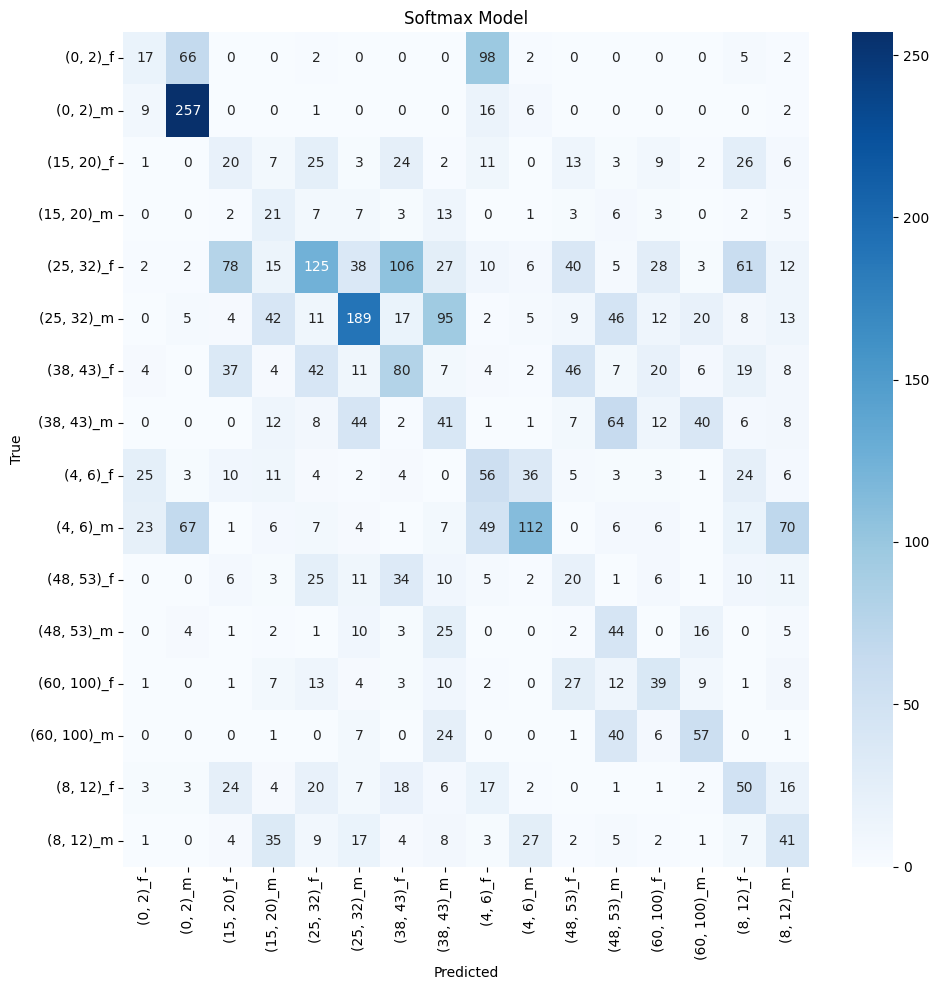

In [11]:
# evaluate the model
softmax_train_preds = softmax_model.predict(train_features)
softmax_train_acc = np.mean(softmax_train_preds == train_labels)
softmax_test_preds = softmax_model.predict(test_features)
softmax_test_acc = np.mean(softmax_test_preds == test_labels)

print("Softmax Model")
print(f"Train Accuracy: {softmax_train_acc:.4f}")
print(f"Test Accuracy: {softmax_test_acc:.4f}")


# Print the classification report
print("Classification Report")
print(
    classification_report(
        test_labels, softmax_test_preds, target_names=combined_encoder.classes_
    )
)

# Plot the confusion matrix
plot_confusion_matrix(
    test_labels,
    softmax_test_preds,
    combined_encoder,
    title="Softmax Model",
    cmap="Blues",
)

### SVM model

In [12]:
svm_model = SVC(kernel="rbf", C=0.01, gamma="scale", probability=True, random_state=42)
svm_model.fit(train_features, train_labels)

# save the model to disk
joblib.dump(svm_model, os.path.join("models", "svm_model_grayscale.pkl"))

['models\\svm_model_grayscale.pkl']

SVM Model
Train Accuracy: 0.2046
Test Accuracy: 0.1781
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.00      0.00      0.00       192
    (0, 2)_m       0.76      0.36      0.49       291
  (15, 20)_f       0.00      0.00      0.00       152
  (15, 20)_m       0.00      0.00      0.00        73
  (25, 32)_f       0.16      1.00      0.27       558
  (25, 32)_m       0.00      0.00      0.00       478
  (38, 43)_f       0.00      0.00      0.00       297
  (38, 43)_m       0.00      0.00      0.00       246
    (4, 6)_f       0.00      0.00      0.00       193
    (4, 6)_m       0.00      0.00      0.00       377
  (48, 53)_f       0.00      0.00      0.00       145
  (48, 53)_m       0.00      0.00      0.00       113
 (60, 100)_f       0.00      0.00      0.00       137
 (60, 100)_m       0.00      0.00      0.00       137
   (8, 12)_f       0.00      0.00      0.00       174
   (8, 12)_m       0.00      0.00      0.00       166

   

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

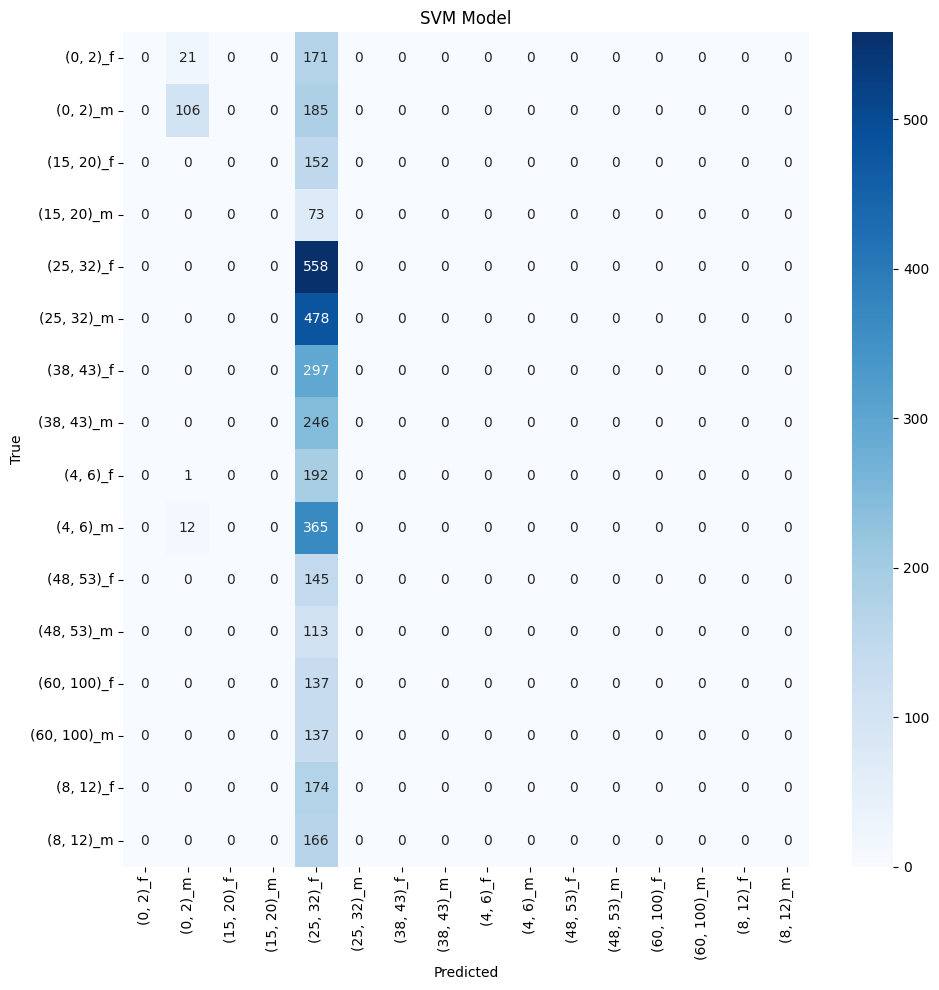

In [13]:
# evaluate the model
svm_train_preds = svm_model.predict(train_features)
svm_train_acc = np.mean(svm_train_preds == train_labels)
svm_test_preds = svm_model.predict(test_features)
svm_test_acc = np.mean(svm_test_preds == test_labels)

print("SVM Model")
print(f"Train Accuracy: {svm_train_acc:.4f}")
print(f"Test Accuracy: {svm_test_acc:.4f}")

# Print the classification report
print("Classification Report")
print(
    classification_report(
        test_labels, svm_test_preds, target_names=combined_encoder.classes_
    )
)

# Plot the confusion matrix
plot_confusion_matrix(
    test_labels, svm_test_preds, combined_encoder, title="SVM Model", cmap="Blues"
)

### random forest model

In [14]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(train_features, train_labels)

# save the model to disk
joblib.dump(rf_model, os.path.join("models", "rf_model_grayscale.pkl"))

['models\\rf_model_grayscale.pkl']

Random Forest Model
Train Accuracy: 0.7730
Test Accuracy: 0.3167
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.50      0.02      0.03       192
    (0, 2)_m       0.47      0.94      0.63       291
  (15, 20)_f       0.00      0.00      0.00       152
  (15, 20)_m       0.00      0.00      0.00        73
  (25, 32)_f       0.28      0.83      0.42       558
  (25, 32)_m       0.32      0.66      0.43       478
  (38, 43)_f       0.00      0.00      0.00       297
  (38, 43)_m       0.27      0.16      0.20       246
    (4, 6)_f       0.24      0.32      0.27       193
    (4, 6)_m       0.69      0.02      0.05       377
  (48, 53)_f       0.00      0.00      0.00       145
  (48, 53)_m       0.00      0.00      0.00       113
 (60, 100)_f       0.00      0.00      0.00       137
 (60, 100)_m       0.00      0.00      0.00       137
   (8, 12)_f       0.24      0.03      0.06       174
   (8, 12)_m       0.19      0.07      0.10     

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

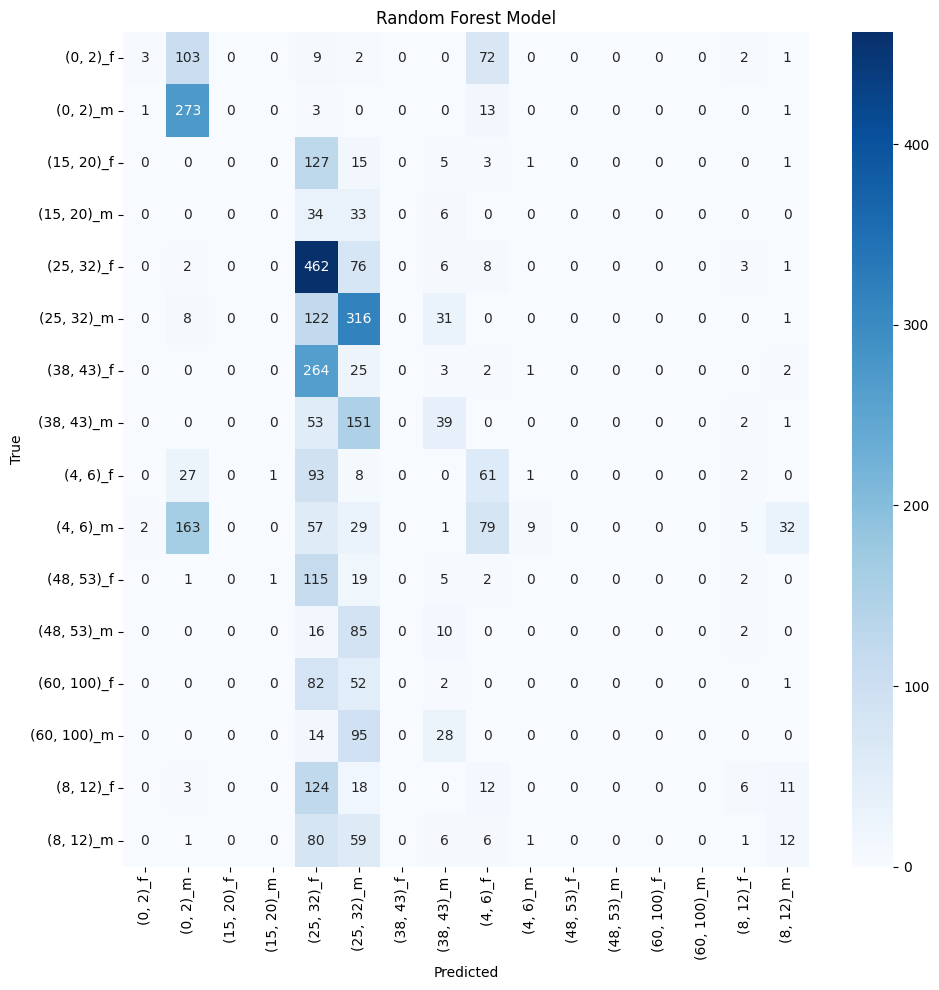

In [15]:
# evaluate the model
rf_train_preds = rf_model.predict(train_features)
rf_train_acc = np.mean(rf_train_preds == train_labels)
rf_test_preds = rf_model.predict(test_features)
rf_test_acc = np.mean(rf_test_preds == test_labels)

print("Random Forest Model")
print(f"Train Accuracy: {rf_train_acc:.4f}")
print(f"Test Accuracy: {rf_test_acc:.4f}")

# Print the classification report
print("Classification Report")
print(
    classification_report(
        test_labels, rf_test_preds, target_names=combined_encoder.classes_
    )
)

# Plot the confusion matrix
plot_confusion_matrix(
    test_labels,
    rf_test_preds,
    combined_encoder,
    title="Random Forest Model",
    cmap="Blues",
)

### Adaboost model

In [16]:
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_model.fit(train_features, train_labels)

# save the model to disk
joblib.dump(adaboost_model, os.path.join("models", "adaboost_model_grayscale.pkl"))

['models\\adaboost_model_grayscale.pkl']

AdaBoost Model
Train Accuracy: 0.3467
Test Accuracy: 0.2650
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.33      0.05      0.09       192
    (0, 2)_m       0.56      0.75      0.64       291
  (15, 20)_f       0.10      0.01      0.01       152
  (15, 20)_m       0.07      0.04      0.05        73
  (25, 32)_f       0.30      0.54      0.39       558
  (25, 32)_m       0.29      0.42      0.34       478
  (38, 43)_f       0.18      0.04      0.07       297
  (38, 43)_m       0.21      0.39      0.27       246
    (4, 6)_f       0.14      0.27      0.19       193
    (4, 6)_m       0.46      0.02      0.03       377
  (48, 53)_f       0.00      0.00      0.00       145
  (48, 53)_m       0.00      0.00      0.00       113
 (60, 100)_f       0.00      0.00      0.00       137
 (60, 100)_m       0.00      0.00      0.00       137
   (8, 12)_f       0.11      0.22      0.14       174
   (8, 12)_m       0.17      0.27      0.21       166

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

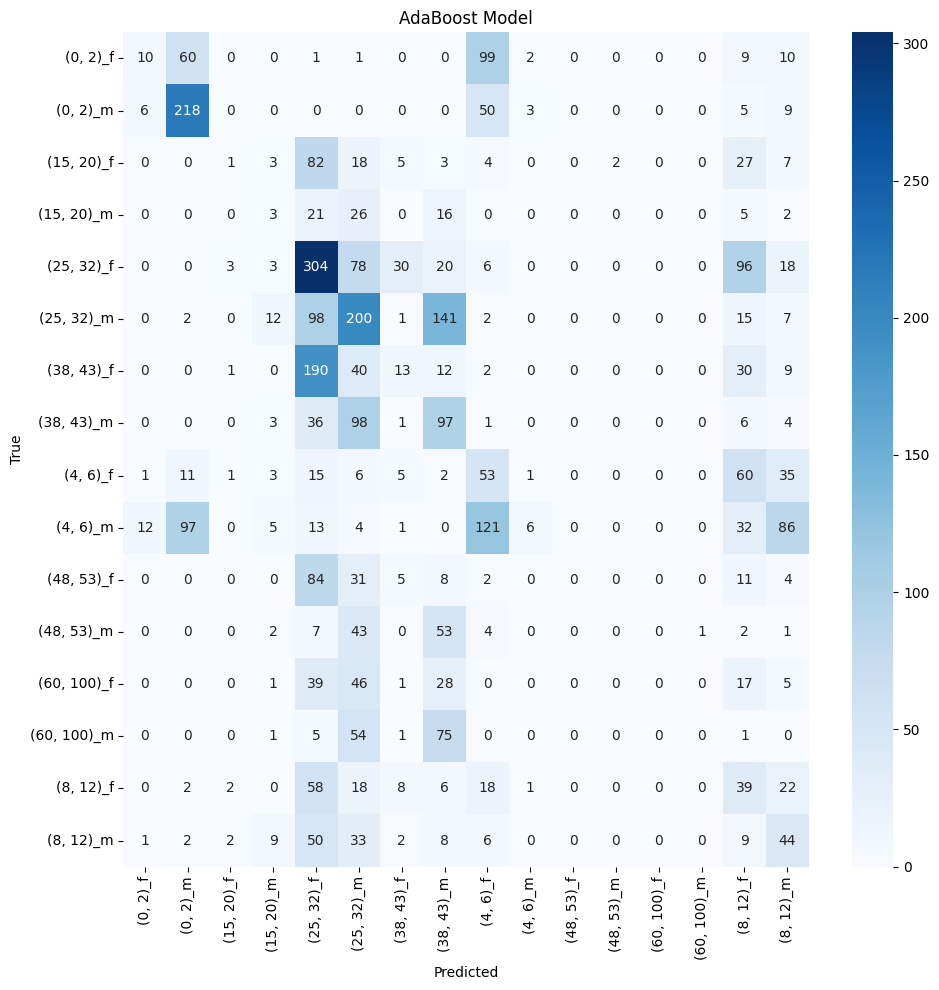

In [17]:
# evaluate the model
adaboost_train_preds = adaboost_model.predict(train_features)
adaboost_train_acc = np.mean(adaboost_train_preds == train_labels)
adaboost_test_preds = adaboost_model.predict(test_features)
adaboost_test_acc = np.mean(adaboost_test_preds == test_labels)

print("AdaBoost Model")
print(f"Train Accuracy: {adaboost_train_acc:.4f}")
print(f"Test Accuracy: {adaboost_test_acc:.4f}")

# Print the classification report
print("Classification Report")
print(
    classification_report(
        test_labels, adaboost_test_preds, target_names=combined_encoder.classes_
    )
)

# Plot the confusion matrix
plot_confusion_matrix(
    test_labels,
    adaboost_test_preds,
    combined_encoder,
    title="AdaBoost Model",
    cmap="Blues",
)

### KNN model

KNN Model with 1 neighbors
Train Accuracy: 0.9998
Test Accuracy: 0.2202
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.23      0.15      0.18       192
    (0, 2)_m       0.58      0.74      0.65       291
  (15, 20)_f       0.10      0.13      0.12       152
  (15, 20)_m       0.03      0.05      0.04        73
  (25, 32)_f       0.27      0.29      0.28       558
  (25, 32)_m       0.28      0.23      0.25       478
  (38, 43)_f       0.17      0.17      0.17       297
  (38, 43)_m       0.16      0.21      0.18       246
    (4, 6)_f       0.16      0.21      0.18       193
    (4, 6)_m       0.25      0.08      0.12       377
  (48, 53)_f       0.06      0.03      0.04       145
  (48, 53)_m       0.14      0.15      0.14       113
 (60, 100)_f       0.18      0.11      0.14       137
 (60, 100)_m       0.18      0.12      0.15       137
   (8, 12)_f       0.11      0.20      0.14       174
   (8, 12)_m       0.10      0.14      0.

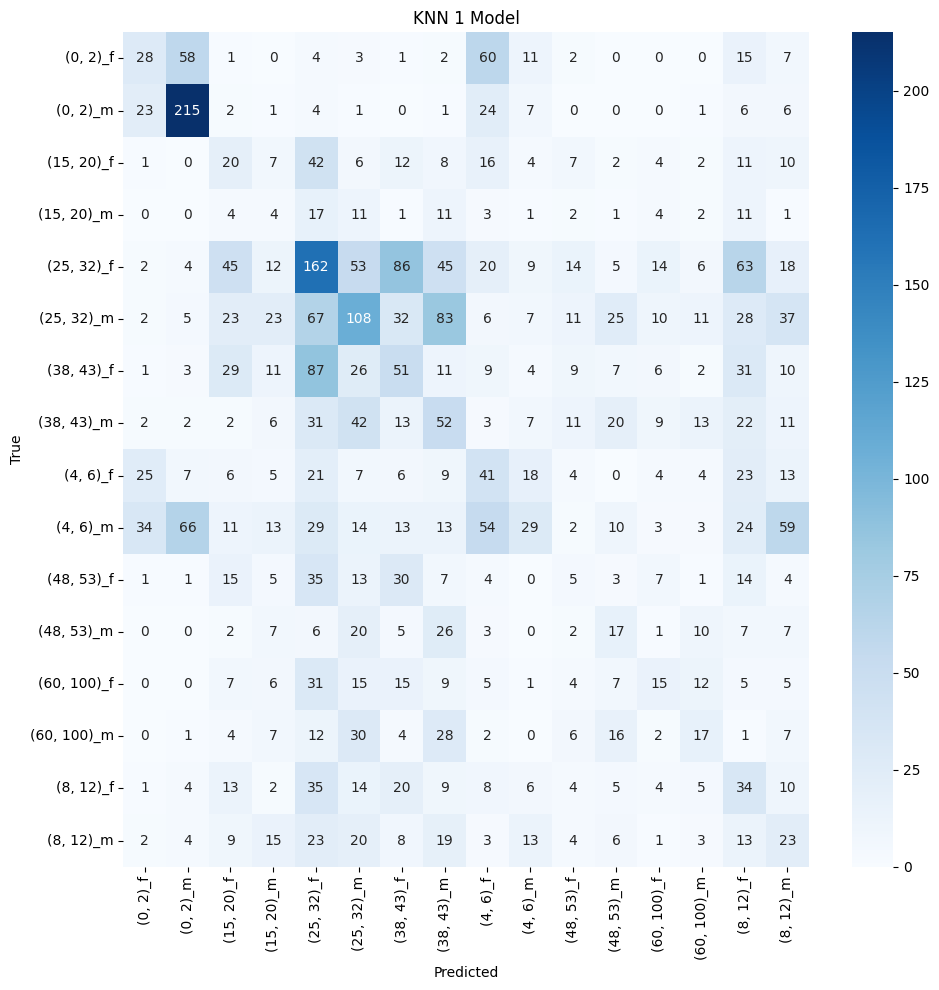

KNN Model with 3 neighbors
Train Accuracy: 0.7525
Test Accuracy: 0.2258
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.19      0.21      0.20       192
    (0, 2)_m       0.52      0.78      0.62       291
  (15, 20)_f       0.08      0.20      0.11       152
  (15, 20)_m       0.04      0.12      0.06        73
  (25, 32)_f       0.25      0.38      0.30       558
  (25, 32)_m       0.32      0.28      0.30       478
  (38, 43)_f       0.15      0.12      0.14       297
  (38, 43)_m       0.15      0.18      0.16       246
    (4, 6)_f       0.18      0.17      0.17       193
    (4, 6)_m       0.35      0.06      0.10       377
  (48, 53)_f       0.09      0.02      0.03       145
  (48, 53)_m       0.16      0.07      0.10       113
 (60, 100)_f       0.23      0.04      0.06       137
 (60, 100)_m       0.26      0.07      0.11       137
   (8, 12)_f       0.10      0.09      0.10       174
   (8, 12)_m       0.08      0.05      0.

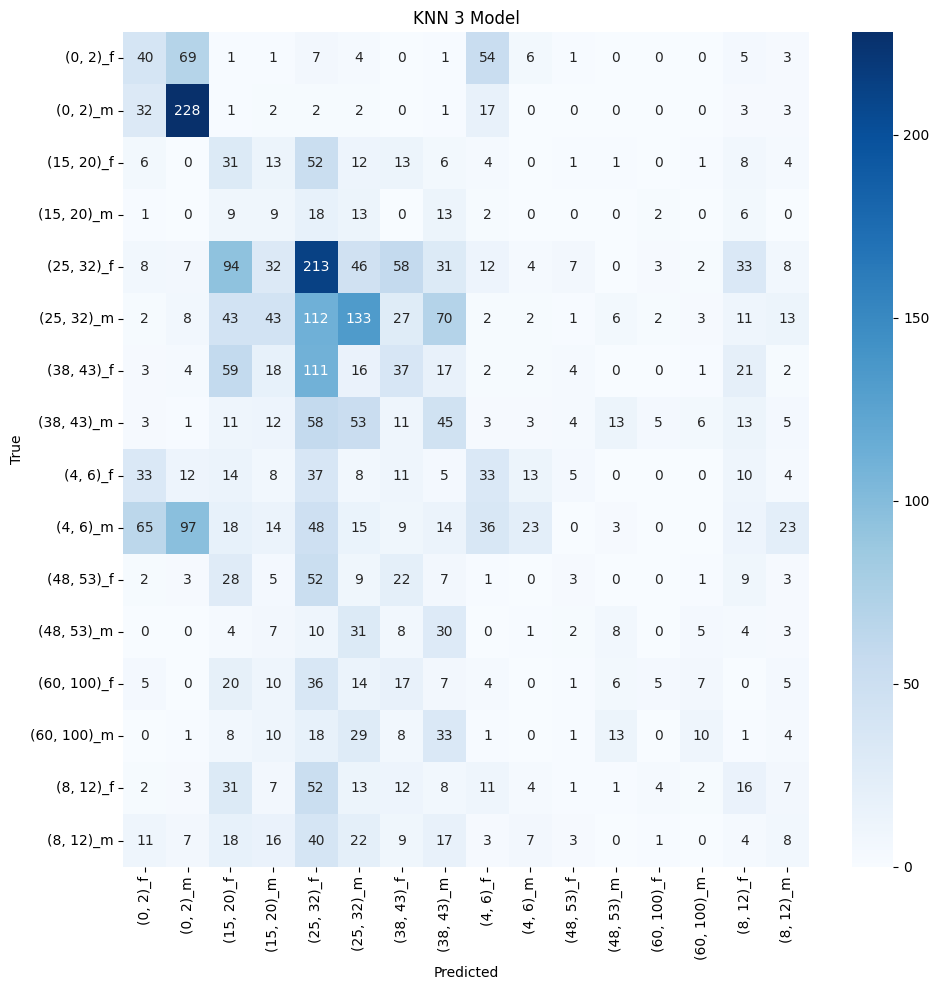

KNN Model with 5 neighbors
Train Accuracy: 0.7001
Test Accuracy: 0.2314
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.16      0.15      0.15       192
    (0, 2)_m       0.53      0.83      0.64       291
  (15, 20)_f       0.06      0.12      0.08       152
  (15, 20)_m       0.04      0.08      0.05        73
  (25, 32)_f       0.26      0.39      0.31       558
  (25, 32)_m       0.33      0.27      0.30       478
  (38, 43)_f       0.17      0.13      0.15       297
  (38, 43)_m       0.16      0.23      0.19       246
    (4, 6)_f       0.19      0.23      0.21       193
    (4, 6)_m       0.42      0.07      0.13       377
  (48, 53)_f       0.00      0.00      0.00       145
  (48, 53)_m       0.20      0.09      0.12       113
 (60, 100)_f       0.18      0.04      0.07       137
 (60, 100)_m       0.19      0.07      0.11       137
   (8, 12)_f       0.07      0.09      0.08       174
   (8, 12)_m       0.09      0.07      0.

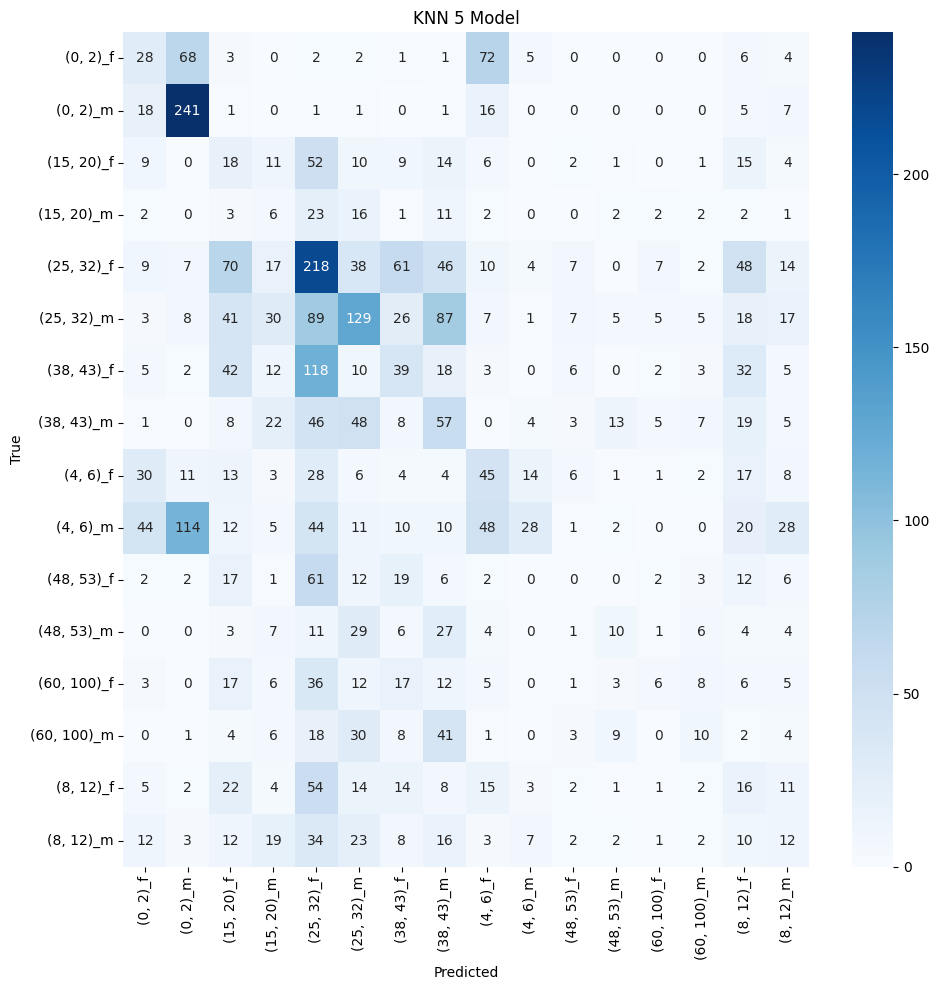

KNN Model with 7 neighbors
Train Accuracy: 0.6631
Test Accuracy: 0.2422
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.16      0.12      0.14       192
    (0, 2)_m       0.54      0.84      0.66       291
  (15, 20)_f       0.07      0.11      0.08       152
  (15, 20)_m       0.03      0.04      0.03        73
  (25, 32)_f       0.26      0.44      0.33       558
  (25, 32)_m       0.36      0.33      0.34       478
  (38, 43)_f       0.17      0.13      0.15       297
  (38, 43)_m       0.16      0.24      0.19       246
    (4, 6)_f       0.19      0.23      0.21       193
    (4, 6)_m       0.41      0.07      0.11       377
  (48, 53)_f       0.00      0.00      0.00       145
  (48, 53)_m       0.12      0.04      0.05       113
 (60, 100)_f       0.11      0.02      0.04       137
 (60, 100)_m       0.20      0.07      0.11       137
   (8, 12)_f       0.08      0.10      0.09       174
   (8, 12)_m       0.09      0.08      0.

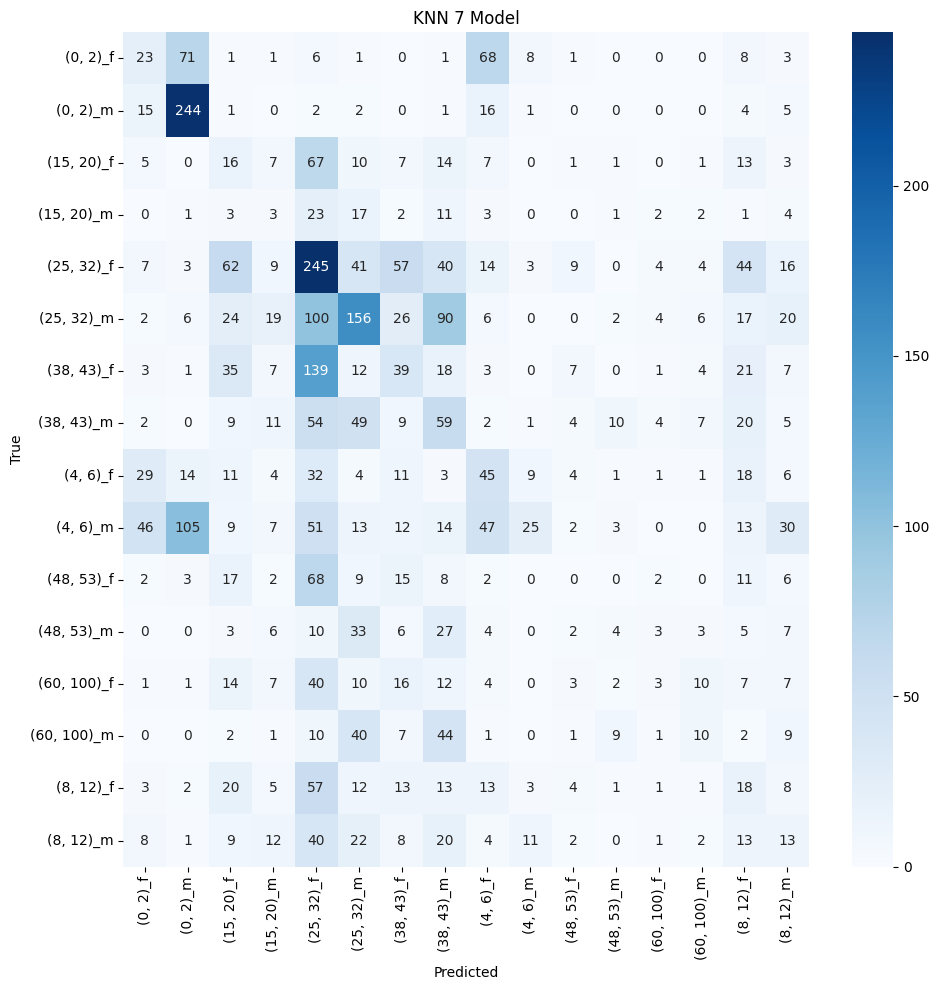

KNN Model with 9 neighbors
Train Accuracy: 0.6331
Test Accuracy: 0.2440
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.16      0.10      0.12       192
    (0, 2)_m       0.53      0.84      0.65       291
  (15, 20)_f       0.07      0.09      0.08       152
  (15, 20)_m       0.06      0.07      0.06        73
  (25, 32)_f       0.26      0.46      0.33       558
  (25, 32)_m       0.33      0.32      0.32       478
  (38, 43)_f       0.17      0.13      0.15       297
  (38, 43)_m       0.15      0.23      0.18       246
    (4, 6)_f       0.17      0.23      0.20       193
    (4, 6)_m       0.47      0.06      0.10       377
  (48, 53)_f       0.00      0.00      0.00       145
  (48, 53)_m       0.17      0.04      0.07       113
 (60, 100)_f       0.22      0.04      0.06       137
 (60, 100)_m       0.21      0.07      0.11       137
   (8, 12)_f       0.10      0.13      0.11       174
   (8, 12)_m       0.10      0.10      0.

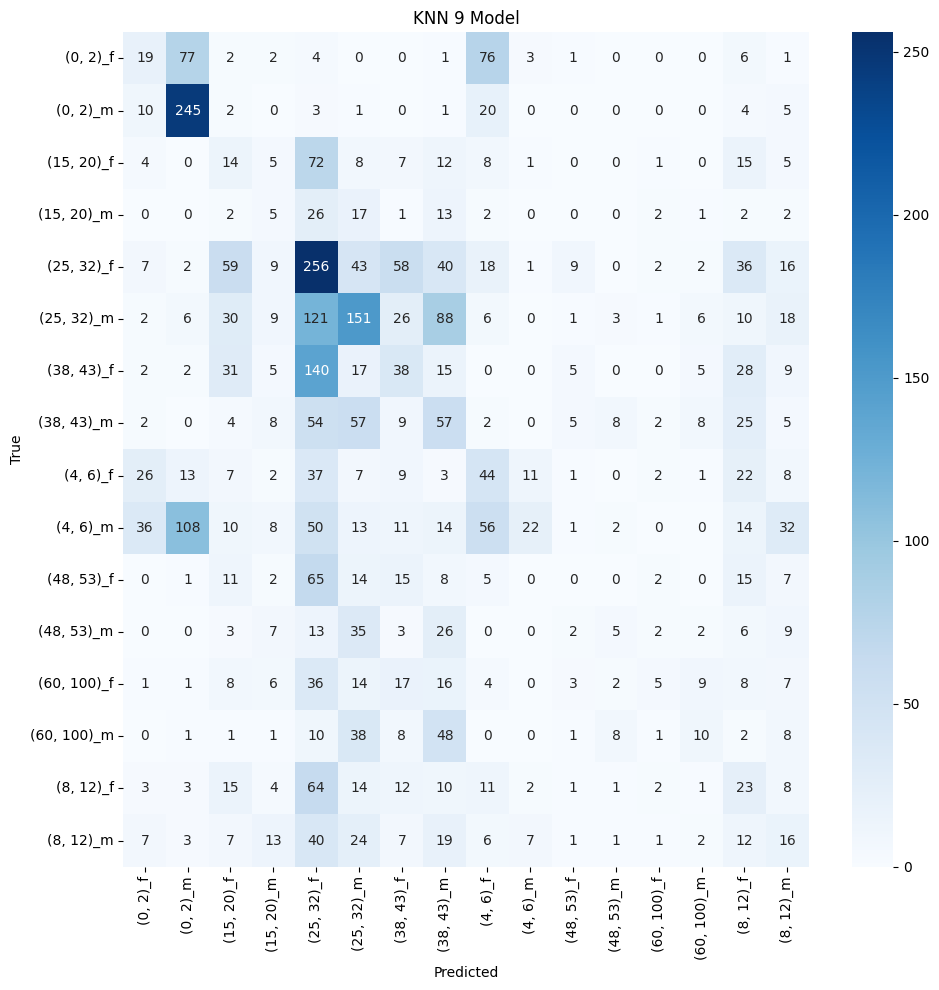

In [18]:
for i in range(1, 10, 2):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(train_features, train_labels)
    knn_train_preds = knn_model.predict(train_features)
    knn_train_acc = np.mean(knn_train_preds == train_labels)
    knn_test_preds = knn_model.predict(test_features)
    knn_test_acc = np.mean(knn_test_preds == test_labels)
    print(f"KNN Model with {i} neighbors")
    print(f"Train Accuracy: {knn_train_acc:.4f}")
    print(f"Test Accuracy: {knn_test_acc:.4f}")
    joblib.dump(knn_model, os.path.join("models", f"knn{i}_model_grayscale.pkl"))
    # Print the classification report
    print("Classification Report")
    print(
        classification_report(
            test_labels, knn_test_preds, target_names=combined_encoder.classes_
        )
    )

    # Plot the confusion matrix
    plot_confusion_matrix(
        test_labels,
        knn_test_preds,
        combined_encoder,
        title=f"KNN {i} Model",
        cmap="Blues",
    )

### Multi-layer model

In [19]:
mlp_model = Sequential(
    [
        Dense(256, activation="relu", input_shape=(train_features.shape[1],)),
        Dropout(0.5),
        BatchNormalization(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        BatchNormalization(),
        Dense(num_classes, activation="softmax"),
    ]
)

mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(train_labels), y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))

mlp_history = mlp_model.fit(
    train_features,
    train_labels,
    validation_data=(val_features, val_labels),
    epochs=15,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
)

# save the model to disk
mlp_model.save(os.path.join("models", "mlp_model_grayscale.h5"))

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1665 - loss: 2.7962 - val_accuracy: 0.3685 - val_loss: 1.7772
Epoch 2/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3043 - loss: 1.9826 - val_accuracy: 0.4317 - val_loss: 1.6009
Epoch 3/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3672 - loss: 1.7764 - val_accuracy: 0.4384 - val_loss: 1.5228
Epoch 4/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3943 - loss: 1.6310 - val_accuracy: 0.4752 - val_loss: 1.4412
Epoch 5/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4340 - loss: 1.4702 - val_accuracy: 0.4934 - val_loss: 1.3915
Epoch 6/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4523 - loss: 1.4037 - val_accuracy: 0.5032 - val_loss: 1.3458
Epoch 7/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4782 - loss: 1.3117 - val_accuracy: 0.5035 - val_loss: 1.3451
Epoch 8/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5050 - loss: 1.2485 - val_accura

371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP Model
Train Accuracy: 0.7521
Test Accuracy: 0.3229
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.16      0.07      0.09       192
    (0, 2)_m       0.69      0.86      0.76       291
  (15, 20)_f       0.10      0.18      0.13       152
  (15, 20)_m       0.11      0.21      0.15        73
  (25, 32)_f       0.39      0.22      0.28       558
  (25, 32)_m       0.55      0.46      0.50       478
  (38, 43)_f       0.25      0.25      0.25       297
  (38, 43)_m       0.22      0.27      0.24       246
    (4, 6)_f       0.20      0.30      0.24       193
    (4, 6)_m       0.54      0.31      0.39       377
  (48, 53)_f       0.13      0.12      0.13       145
  (48, 53)_m       0.21      0.44      0.28       113
 (60, 100)_f       0.31      0.31      0.31       137
 (60, 100)_m       0.42      0.36      0.39       137
   (8, 12)_f       0.20      0

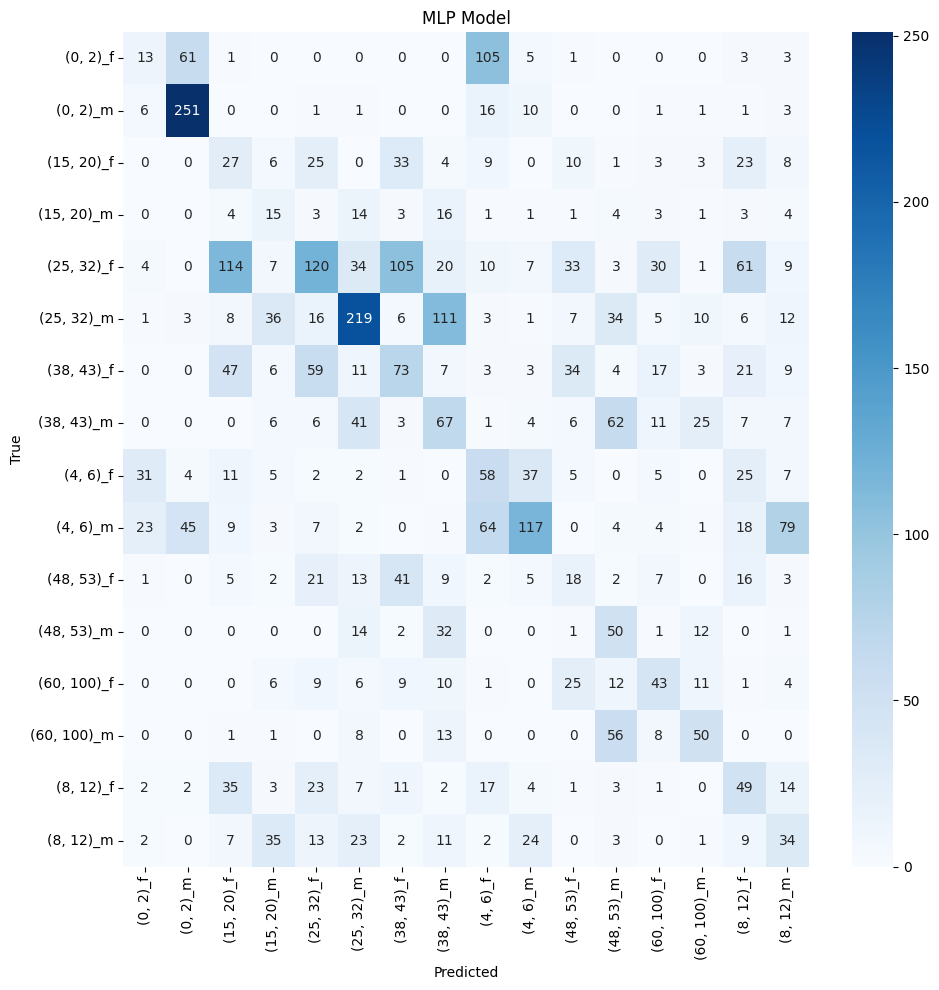

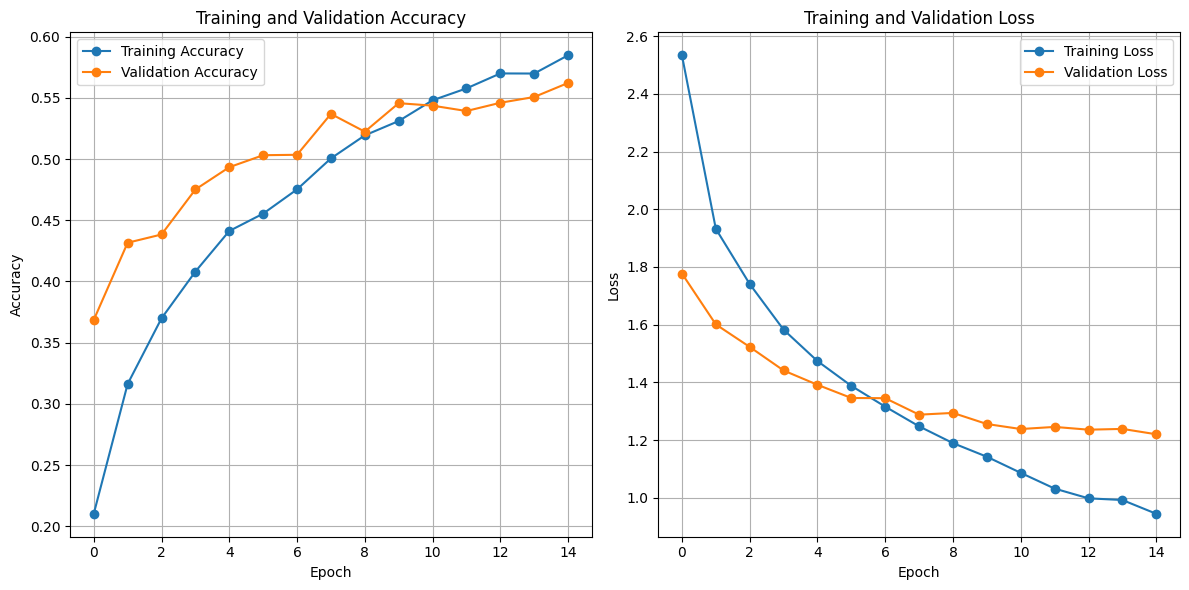

In [ ]:
# evaluate the model
mlp_train_preds = mlp_model.predict(train_features)
mlp_train_acc = np.mean(np.argmax(mlp_train_preds, axis=1) == train_labels)
mlp_test_preds = mlp_model.predict(test_features)
mlp_test_acc = np.mean(np.argmax(mlp_test_preds, axis=1) == test_labels)

print("MLP Model")
print(f"Train Accuracy: {mlp_train_acc:.4f}")
print(f"Test Accuracy: {mlp_test_acc:.4f}")

# Print the classification report
print("Classification Report")
print(
    classification_report(
        test_labels,
        np.argmax(mlp_test_preds, axis=1),
        target_names=combined_encoder.classes_,
    )
)

# Plot the confusion matrix
plot_confusion_matrix(
    test_labels,
    np.argmax(mlp_test_preds, axis=1),
    combined_encoder,
    title="MLP Model",
    cmap="Blues",
)

# Plot the training history
plot_training_history(mlp_history)

### CNN model
this model does not use the extracted features, it uses the images directly

In [10]:
# Build CNN Architecture
cnn_model = Sequential()

# Add convolutional layers with ReLU activation and max pooling
cnn_model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1)))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation="relu"))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation="relu"))
cnn_model.add(MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
cnn_model.add(Flatten())

# Add dense layers with dropout for regularization
cnn_model.add(Dense(512, activation="relu"))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dropout(0.5))

# Output layer with softmax activation for classification
cnn_model.add(Dense(len(combined_encoder.classes_), activation="softmax"))

# Compile the cnn_model
cnn_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Validation and test data should not be augmented, only rescaled
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col="img_path",
    y_col="encoded_label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="raw",
    color_mode='grayscale'
)

val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col="img_path",
    y_col="encoded_label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="raw",
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col="img_path",
    y_col="encoded_label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="raw",
    color_mode='grayscale'
)

Found 11850 validated image filenames.
Found 2963 validated image filenames.
Found 3729 validated image filenames.


In [15]:
# Train the model
cnn_history = cnn_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping],
)

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - accuracy: 0.1465 - loss: 2.6391 - val_accuracy: 0.1988 - val_loss: 2.5293
Epoch 2/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 152s 410ms/step - accuracy: 0.1885 - loss: 2.5527 - val_accuracy: 0.2389 - val_loss: 2.4012
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.2266 - loss: 2.4610 - val_accuracy: 0.2535 - val_loss: 2.3452
Epoch 4/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 134s 362ms/step - accuracy: 0.2375 - loss: 2.4134 - val_accuracy: 0.2889 - val_loss: 2.2074
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.2480 - loss: 2.3593 - val_accuracy: 0.2929 - val_loss: 2.1415
Epoch 6/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 290s 784ms/step - accuracy: 0.2736 - loss: 2.2682 - val_accuracy: 0.3392 - val_loss: 2.0057
Epoch 7/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 136s 368ms/step - accuracy: 0.2857 - loss: 2.2241 - val_accuracy: 0.3547 - val_loss: 1.9763
Epoch 8/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 120s 324ms/step - accuracy: 0.2850 - lo

In [16]:
# Save the model
cnn_model.save(os.path.join("models", "cnn_model_grayscale.h5"))

117/117 ━━━━━━━━━━━━━━━━━━━━ 58s 493ms/step - accuracy: 0.3164 - loss: 2.1368
Test Loss: 2.133622884750366
Test Accuracy: 0.31536605954170227
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step
Classification Report
              precision    recall  f1-score   support

    (0, 2)_f       0.02      0.01      0.01       192
    (0, 2)_m       0.07      0.12      0.09       291
  (15, 20)_f       0.00      0.00      0.00       152
  (15, 20)_m       0.04      0.04      0.04        73
  (25, 32)_f       0.15      0.34      0.20       558
  (25, 32)_m       0.11      0.20      0.14       478
  (38, 43)_f       0.00      0.00      0.00       297
  (38, 43)_m       0.08      0.04      0.06       246
    (4, 6)_f       0.04      0.07      0.05       193
    (4, 6)_m       0.04      0.01      0.01       377
  (48, 53)_f       0.00      0.00      0.00       145
  (48, 53)_m       0.00      0.00      0.00       113
 (60, 100)_f       0.00      0.00      0.00       137
 (60, 100)_m       0.02      0.01  

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

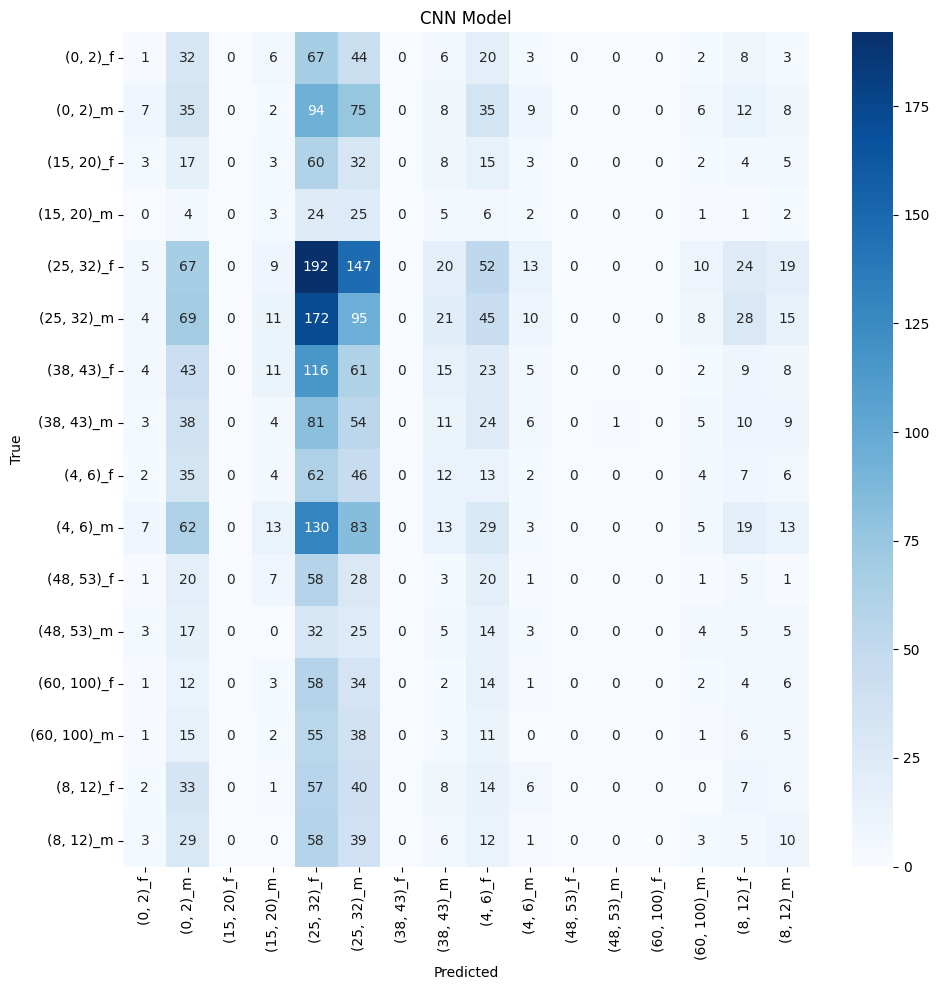

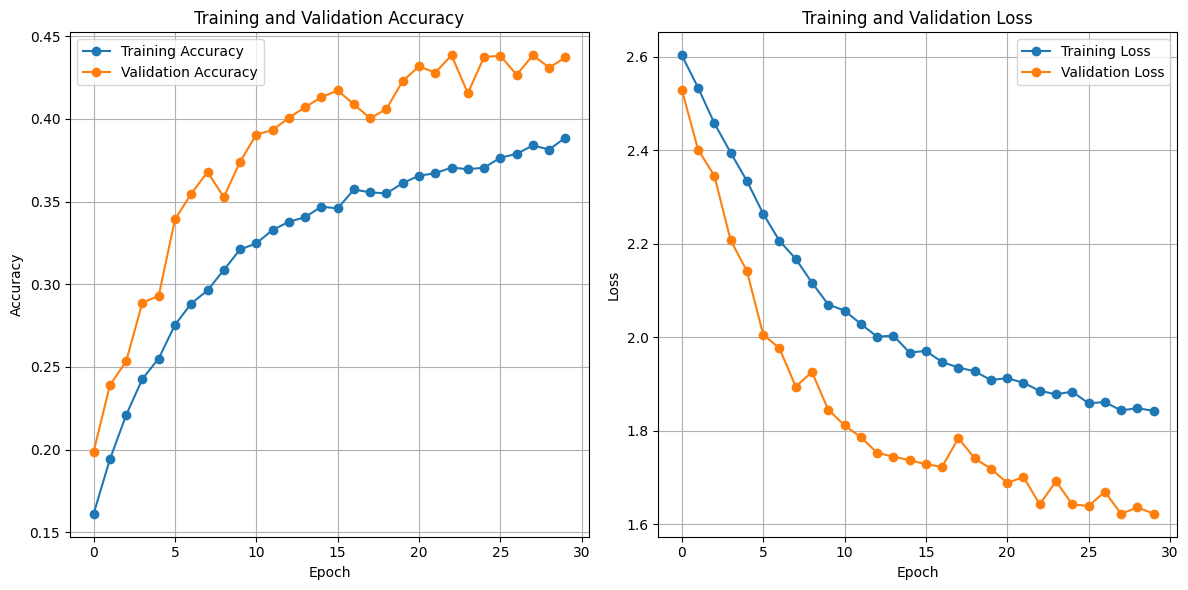

In [17]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict the labels for the test set
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data["encoded_label"].values

# Print the classification report
print("Classification Report")
print(
    classification_report(
        y_true, y_pred_classes, target_names=combined_encoder.classes_
    )
)

# Plot the confusion matrix
plot_confusion_matrix(
    y_true, y_pred_classes, combined_encoder, title="CNN Model", cmap="Blues"
)

# Plot the training history
plot_training_history(cnn_history)

### Example of using a model

In [ ]:
def predict_image(model_name, image_path):
    """
    Predict age/gender class for a single image using the specified model.

    Parameters:
    -----------
    model_name : str
        Name of the model file in the 'models' directory (without path)
    image_path : str
        Path to the image file

    Returns:
    --------
    dict
        Dictionary containing prediction class, confidence, and model info
    """
    # Construct full model path
    model_path = os.path.join("models", model_name)

    # Load the model
    if model_name.endswith(".h5"):
        # For Keras models
        model = tf.keras.models.load_model(model_path)
    else:
        # For scikit-learn models
        model = joblib.load(model_path)

    # Load label encoder and scaler
    combined_encoder = joblib.load(os.path.join("models", "combined_encoder.pkl"))
    combined_scaler = joblib.load(os.path.join("models", "combined_scaler.pkl"))

    # Extract features using grayscale2emb
    features = grayscale2emb([image_path])

    # Preprocess features using the scaler
    features_scaled = combined_scaler.transform(features)

    # Make prediction
    is_keras_model = model_name.endswith(".h5")

    if is_keras_model:
        # For Keras models
        probs = model.predict(features_scaled)[0]
        predicted_class_idx = np.argmax(probs)
        confidence = float(probs[predicted_class_idx])
    else:
        # For sklearn models
        predicted_class_idx = model.predict(features_scaled)[0]

        # Get confidence (probability)
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(features_scaled)[0]
            confidence = float(probs[predicted_class_idx])
        else:
            # For models without probability estimates
            confidence = None

    # Get the class label
    predicted_class = combined_encoder.classes_[predicted_class_idx]

    return {
        "model": model_name,
        "prediction": predicted_class,
        "confidence": confidence,
        "class_index": int(predicted_class_idx),
    }